# Lab 03: Numerical Derivatives

## Objectives

The main focus of this lab is to study numerical derivatives using center differencing and Richardson extrapolation.  We will also learn about the dangers of calculating numerical derivatives of noisy data.  You should *not* need to use any loops in this lab! (Besides the ones that appear in the `richardson_center` function, of course.)

## Initialization

As always initialize, your environment now by loading all modules required and setting up the plotting environment. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.optimize as opt
import scipy.interpolate as interp
import matplotlib as mpl
mpl.rc('xtick', direction='in', top=True)
mpl.rc('ytick', direction='in', right=True)
mpl.rc('xtick.minor', visible=True)
mpl.rc('ytick.minor', visible=True)

## Derivatives of Data

One reason why calculating numerical derivatives is not too common is that calculating numerical derivatives of data is something that must be done with great care.  The main reason for this is that data is noisy.  Here you will explore that.  We again consider a simple function,
$$ f(\theta) = \sin\theta, $$
for which the derivative is simply
$$ f'(\theta) = \cos\theta. $$

Suppose we take measurements of this function at 20 equally spaced points in the interval $0\le\theta\le 2\pi$.  An actual measurement has uncertainties which are often Gaussian distributed.  We will model our errors by *adding* Gaussian random noise to the true values from a distribution with variance (width) of 0.2.  Recall from Lab 0 that we can choose Gaussian random variables using the `randn` function.  We can properly access this function as `np.random.randn` (assuming the usual alias for `numpy`).  This will return random values with variance 1, to change this to 0.2 just multiply the returned values by 0.2 before adding it to the true function values.

Once you have generated the "data" we want to take its derivative using center differencing.  Since center differencing uses values to the left and right of where we are calculating the derivative we are unable to calculate it at the first and last points.  (We could correct this by using forward and backward differencing at these points or the higher order methods discussed in class, but will not do so here.)  How do we calculate all the required derivatives without writting a loop?  Once again we will use array slicing! (At this point you should start to appreciate that array slicing is very powerful.  We will see it in more detail soon.)  Notice that for $N$ points we want to calculate the derivatives
$$\begin{align}
 f'_1 &= \frac{f_2-f_0}{2h}, \\
 f'_2 &= \frac{f_3-f_1}{2h}, \\
 \vdots &= \vdots \\
 f'_{n-2} &= \frac{f_{n-1}-f_{n-3}}{2h}.
 \end{align}
 $$
To calculate all the derivatives we are taking the values $f_2$, $f_3$, $\ldots$, $f_{n-1}$ and subtracting off $f_0$, $f_1$, $\ldots$, $f_{n-3}$.  Given an array, `a`, we can access the first set of values as `a[2:]` and the second set as `a[:-2]`.  (Read that again carefully!)  Using this slicing in the calculation we will get an array back with $n-2$ entries corresponding to derivatives at the points $\theta_1$, $\theta_2$, $\ldots$, $\theta_{n-2}$.  Given an array of values `theta` as specified above, how can we slice it to only get these values? (This will be useful for the plot below.)

Put all this together and produce a single plot.
1. Create your noisy data.
2. Plot points for the noisy data and a (smooth) curve showing the true function from the which the data was generated.
3. Calculate the numerical derivative of your noisy data using center differencing.
4. Plot points for the derivative of the noisy data and a (smooth) curve showing the true derivative.

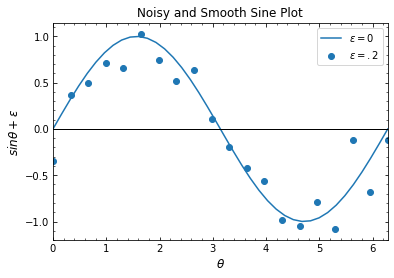

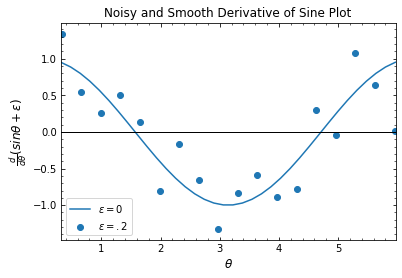

In [2]:
##Create noisy data and smooth data of sine
theta = np.linspace(0, 2 * np.pi, 20)
noise = .2 * np.random.randn(20)
noisy_data = np.sin(theta) + noise
theta_fine = np.linspace(0, 2 * np.pi, 10*4)

#Plot noisy and smooth data of sine
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(theta, noisy_data, label = r'$\epsilon = .2$')
ax.plot(theta_fine, np.sin(theta_fine), label = r'$\epsilon = 0$')
ax.legend()
ax.set_title('Noisy and Smooth Sine Plot')
ax.set_xlabel(r'$\theta$', fontsize = 'large')
ax.set_ylabel(r'$sin\theta + \epsilon$', fontsize = 'large')
ax.axhline(0,color='black',linewidth=1)
plt.xlim(0, 2 * np.pi)

#Make noisy data of the derivative of sine
h = np.pi / 10
d_noisy_data = (noisy_data[2:] - noisy_data[:-2]) / (2 * h)

#Plot noisy and smooth data of the derivative of sine
fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
ax2.scatter(theta[1:19], d_noisy_data, label = r'$\epsilon = .2$')
ax2.plot(theta_fine, np.cos(theta_fine), label = r'$\epsilon = 0$')
ax2.legend()
ax2.set_title('Noisy and Smooth Derivative of Sine Plot')
ax2.set_xlabel(r'$\theta$', fontsize = 'large')
ax2.set_ylabel(r'$\frac{d}{d\theta}(sin\theta + \epsilon)$', fontsize = 'large')
ax2.axhline(0,color='black',linewidth=1)
plt.xlim(np.pi / 10, 2 * np.pi - np.pi / 10);

Based on your results briefly describe the danger of taking derivative of noisy data.  (You may want to run you code a few times to see how things change when different random data is generated.)

The derivatives of the noisy data can be very far from the true value.  In fact, the derivative could even have the wrong sign!  This is due to the fact that noise can cause the actual value to move upward or downward.  Though this does not have much effect on the actual value of the function, it can have a very large effect on the slope of the function, ie, its derivative.

## Derivatives of Bessel Functions

The solution to many physical problems involve special functions.  One example is the set of Bessel functions.  If you have not encountered them yet you will, they typically show up in systems with cylindrical symmetry.  There are many types of Bessel functions but we will focus on the ordinary Bessel functions of order $\nu$ and of the first kind, $J_\nu(x)$, and the second kind, $Y_\nu(x)$ (sometimes also called the Neumann function and denoted $N_\nu(x)$).  Note that we are considering $\nu$ to be a real number.

Here we will consider taking the derivative with respect to the order, $\nu$, **not the derivative with respect to $x$**.  Admittedly this is rather a contrived example, but it is difficult to find an interesting and compelling example of numerical derivatives.

To begin we will take the derivative evaluated at $\nu=0$.  Mathematically we know the result,
$$ \left. \frac{\mathrm{d}J_\nu(x)}{\mathrm{d}\nu} \right|_{\nu=0} = \frac\pi{2} Y_0(x). $$
We will compare this result to numerical calculations using forward and center differencing.  **Note:** We are calculating the *derivative with respect to the order*, $\nu$, **not** with respect to the argument $x$.  We do not normally think about taking derivatives like this, but we certainly can and will do so here.

### Special Functions in Python

The Bessel functions and many of the other important special functions are not part of the `numpy` module. The simplest way to access such functions for us will be with the module `scipy.special`. For a list of the special functions (and how to use them) check the documentation!

Suppose we `import scipy.special as sf`. For us the relevant functions are `sf.jv` or `sf.jn` for Bessel functions of the first kind and `sf.yv` or `sf.yn` for the second kind. Here the `v` in the name represents what we have been calling $\nu$ and is used when the order is a real number.  Similarly, `n` in the name represents when $\nu=n$ is an integer.  Furthermore, for small (integer) values of $n$ there is often an explicit implementation of that function. For example the special function $Y_0(x)$ can be called as `sf.y0(x)`, as `sf.yn(0,x)`, or as `sf.yv(0,x)`.  You should prefer the first over the second and the second over the third.  In other words, it is typically best to use the most specific form of the function that is available.  Again, check the documentation just like we do when going over examples!

### Simple Calculation

Calculate the derivative for $x=1.5$ of $J_\nu(x)$ at $\nu=0$. Let $h=0.5$.  Evaulate this derivative using both forward and center differencing for step sizes of both $h$ and $h/2$.  Print the fractional error for all cases. **Note:** Recall that we are taking the derivative with respect to $\nu$ **not** with respect to $x$. Also recall the lesson we learned when talking about limited precision.  What is the "right" way to calculate the step size, $h$? Does it matter here? Why or why not?

In [3]:
#Import special functions
import scipy.special as sf

#Calculate derivative analytically
x = 1.5
d_jv_analytical = np.pi / 2 * sf.y0(x)
print('The analytical derivative is', d_jv_analytical)

#Calculate h the right way, by differencing the x-values for each pair of points. This doesn't matter very much for us, though, because all of our points are evenly spaced.
h10 = .9
h = h10 + x
h -= x

#Make a variable for number of iterations
N = 6

#Make a variable for order
v = 0

#Caclulate derivative with forward differencing and its error using h
d_jv_forward = (sf.jv(v + h, x) - sf.jv(v, x)) / h
err_forward = np.absolute((d_jv_forward - d_jv_analytical) / d_jv_analytical)
print('The forward differncing derivative is', str(d_jv_forward) + ', and the error is', err_forward, 'when using h')

#Calculate derivative with center differencing and its error using h 
d_jv_center = (sf.jv(v + h, x) - sf.jv(v - h, x)) / (2 * h)
err_center = np.absolute((d_jv_center - d_jv_analytical) / d_jv_analytical)
print('The center differencing derivative is', str(d_jv_center) + ', and the error is', err_center, 'when using h')

#Caclulate derivative with forward differencing and its error using h/2
d_jv_forward2 = (sf.jv(v + h / 2, x) - sf.jv(v, x)) / (h / 2)
err_forward2 = np.absolute((d_jv_forward2 - d_jv_analytical) / d_jv_analytical)
print('The forward differncing derivative is', str(d_jv_forward2) + ', and the error is', err_forward2, 'when using h/2')

#Calculate derivative with center differencing and its error using h/2 
d_jv_center2 = (sf.jv(v + h / 2, x) - sf.jv(v - h / 2, x)) / h
err_center2 = np.absolute((d_jv_center2 - d_jv_analytical) / d_jv_analytical)
print('The center differencing derivative is', str(d_jv_center2) + ', and the error is', err_center2, 'when using h/2')

The analytical derivative is 0.600749364688181
The forward differncing derivative is 0.08345553277237122, and the error is 0.8610809471006453 when using h
The center differencing derivative is 0.5764557767375723, and the error is 0.04043880756031801 when using h
The forward differncing derivative is 0.30487132267160444, and the error is 0.49251494784376854 when using h/2
The center differencing derivative is 0.6039634452013701, and the error is 0.00535011887171522 when using h/2


### Richardson Extrapolation

Next we want to study the same case but now with Richardson extrapolation applied to center differencing.  Provide the code for performing Richardson extrapolation below.  Yes, you *can* just copy this from the example or the prelab!

###### Code for Richardson Extrapolation of Center Differencing:

In [4]:
def richardson_center (f, z, h, nsteps, args=()) :
    """Evaluate the first derivative of a function at z, that is f'(z),
    using Richardson extrapolation and center differencing.

    Returned is the full table of approximations, Fij for j <= i. The
    values of Fij for j > i are set to zero.  The final value F[-1,-1]
    should be the most accurate estimate.

    Parameters
    ----------
    f : function
        Vectorized Python function.
        This is the function for which we are estimating the derivative.
    z : number
        Value at which to evaluate the derivative.
    h : number
        Initial stepsize.
    nsteps : integer
        Number of steps to perform.
    args : tuple, optional
        extra arguments to pass to the function, f.
    """
    # Extra check to allow for args=(1) to be handled properly.  This is a
    # technical detail that you do not need to worry about.
    if not isinstance(args, (tuple, list, np.ndarray)) :
        args = (args,)
    # Create a zero filled table for our estimates
    F = np.zeros((nsteps,nsteps))
    # First column of F is the center differencing estimate.  We can fill this
    # without a loop!
    harr = h / 2.**np.arange(nsteps)
    F[:,0] = (f(z+harr,*args) - f(z-harr,*args)) / (2.*harr)
    # Now iterate, unfortunately we do need one loop.  We could
    # get rid of the inner loop but the algorithm is a little easier to
    # understand if we do not.
    fact = 1.0
    for i in range(1,nsteps) :
        fact *= .25
        for j in range(1,i+1) :
            F[i,j] = F[i-1,j-1] - (F[i-1,j-1] - F[i,j-1])/ (1-fact)
    return F

Calculate 25 steps of Richardson extrapolation for the case we have been studying.  Produce a figure showing the absolute error of the best estimate from Richardson extrapolation at each step.  Also include the convergence rate in this plot.  Notice that we are taking the derivative using the function `sf.jv` and this function takes two arguments.  How do we handle that?

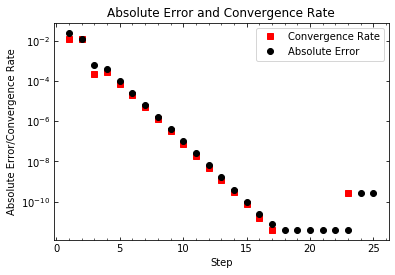

In [5]:
#Calculate 25 steps of Richardson extrapolation with center differencing
d_jv_center_richardson = np.diag(richardson_center(sf.jv, v, h, 25, x))

#Caclculate absolute error
err_center_richardson = np.absolute(d_jv_analytical - d_jv_center_richardson)

#Calculate convergence rate
cr = np.abs(np.diff(err_center_richardson))

#Make array for steps
n = np.arange(1, 26)

#Plot convergence rate and absolute error
fig = plt.figure()
ax = fig.add_subplot(111)
plt.semilogy(n[:-1], cr, 'rs', label = 'Convergence Rate')
plt.semilogy(n, err_center_richardson, 'ko',  label = 'Absolute Error')
plt.legend()
plt.xlabel('Step')
plt.ylabel('Absolute Error/Convergence Rate')
plt.title('Absolute Error and Convergence Rate');

Notice that the error and convergence rate agree fairly well until about step 17 or 18.  What happens here?  Why does the error start to grow?

Here is where round off error, or the limited precision of the computer becomes important.  The corrections that we are trying to apply are so small that the "numerical noise" dominates.  Since subsequent estimates depend on the previous ones these errors begin to grow.

### Derivative at Arbitrary Integer Order

The derivative can actually be calculated at any arbitrary integer order, $n$.  Mathematically this is given by
$$ \left. \frac{\mathrm{d}J_\nu(x)}{\mathrm{d}\nu} \right|_{\nu=n} = \frac\pi{2} Y_n(x) + \frac{n!}{2(x/2)^n} \sum_{k=0}^{n-1} \frac{(x/2)^k J_k(x)}{(n-k) k!}. $$
Here we will explore this more general relationship.

#### Small Order

Calculate the derivative for $n=4$ using Richardson extrapolation with 8 steps.  Print the *fractional error* in the best estimate.  Recall from the prelab that we can calculate the true value without using loops by instead using the `sum` function.

In [6]:
#Make variable for integer order
n = 4

#Calculate derivative from the math
k = np.arange(0, n)
def f(k) :
    '''Calculates the argument in the sum from the derivate at arbitrary integer order
    k : array of integers from 0 to n - 1, where n is the order'''
    return (x / 2) ** k * sf.jn(k, x) / ((n - k) * sf.factorial(k))
djv = np.pi / 2 * sf.yn(n, x) + sf.factorial(n) / (2 * (x / 2) ** n) * np.sum(f(k))  

#Caclculate derivative with Richardson extrapolation
djvr = richardson_center(sf.jv, n, h, 8, x)

#Calculate fractional error of best estimate
err = np.abs((djv - djvr[-1, -1]) / djv)
print(err)

1.984932235482333e-05


#### Large Order

You may wonder why we are bothering with the numerical derivative since we have an analytic expression.  It is not *just* to keep you busy.  There are occasions when the analytic expression is not numerically useful.  This is one such case.

Calculate the derivative again using 8 steps of Richardson extrapolation and the analytic expression but now for $\nu=40$.  Print the best estimate from Richardson extrapolation and also the value from the analytic expression.  (*Note:* It will be convenient for the discussion below to calculate and store the two terms in the analytic expression separately.)

In [7]:
#Assign 40 to variable for integer order
n = 40

#Caclulate derivative from analytic expression
k = np.arange(0, n)
term1 = np.pi / 2 * sf.yn(n, x)
term2 = sf.factorial(n) / (2 * (x / 2) ** n) * np.sum(f(k))
djv = term1 + term2
print('The derivative from the analytic expression is', djv)

#Caclculate derivative with Richardson extrapolation
djvr = richardson_center(sf.jv, n, h, 8, x)
print('The derivative from Richardson extrapolation is', djvr[-1, -1])

The derivative from the analytic expression is 3.32306998946229e+35
The derivative from Richardson extrapolation is -4.849884454413589e-53


The answers should be entirely inconsistent.  What happened and which one do you believe?  To explore this print the two terms from the analytic expression.  Do you see a problem?

In [8]:
print(term1)
print(term2)

-1.028891543072057e+51
1.0288915430720573e+51


Based on the previous part which estimate do you believe is the correct one for the derivative?  Explain why you believe this estimate and what went wrong with the other one.

We believe the derivative from Richardson extrapolation is the correct one because the two terms from the analytical expression are equal opposites to many digits. We believe the analytical method failed because the second term ballooned with the high n-value, which caused a failure due to memory constraints. The second term had one additional digit which is on the order of $10^{35}$ and caused the computer to return a number on the order of $10^{35}$ instead of zero. The Richardson Equation is designed to keep errors like these in check, and so performs better for large n.

## Member Participation

See Lab00 for instructions on turning in labs.  We will follow this procedure the entire semester.

In the following cell enter the *Case ID* for each student in the group who partcipated in this lab.  Again, see Lab00 for more details.  It is expected that you have read and understood those details.

mrb175
<br>
kls188
<br>
gbs32